In [ ]:
!pip install datasets transformers peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,pipeline
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

In [ ]:
dataset = load_dataset("yelp_review_full", split="train[:5000]").train_test_split(test_size=0.1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
print("Sample count:", len(dataset['train']))
print("Example sample:")
print(dataset['train'][0])

Sample count: 4500
Example sample:
{'label': 2, 'text': 'My worst dining experience while working in Pittsburgh. Up until tonight I\'ve thought \\"these are the nicest people I\'ve met\\" more than any other city I\'ve worked in recently. Soba\'s staff has cured me of that. Food was good not great and my server acted as though my table of one was a bother even though I spent 60 bucks and ate within an hour with a 20% tip. My co workers were interested in checking this place out before we all head back to Los Angeles but I\'ll let them all know it\'s not worth a visit. Pittsburgh has some great restaurants but this is not one of them.'}


In [ ]:
from collections import Counter
labels = [example['label'] for example in dataset['train']]
print("Label Distribution:", Counter(labels))

Label Distribution: Counter({1: 1020, 2: 1015, 3: 879, 4: 800, 0: 786})


In [ ]:
print("\nRandom Samples:")
for i in random.sample(range(len(dataset['train'])), 3):
    print(f"⭐ {dataset['train'][i]['label'] + 1} star")
    print(dataset['train'][i]['text'][:200], '...')
    print()




Random Samples:
⭐ 2 star
This Starbucks is teeny-tiny!\n\nSeating inside is VERY limited.  This is a Starbucks to grab and go and continue your shopping at the Waterfront.\n\nBaristas are friendly and fast. ...

⭐ 4 star
This hidden gem, tucked away in the corner of Market Square in downtown Pittsburgh, offers more than just coffee.  Sure, it's easy to be lazy and unadventurous and go to Dunkin Donuts or Starbucks, bu ...

⭐ 2 star
Lidia's is an upscale Olive Garden with slightly better wine list.\n\nThe biggest problem?  Everything is bland. They have a salt problem. They must not have it in their kitchen. Everything needed it. ...



# Tokenization

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(example):
    return tokenizer(example['text'], truncation=True, padding="max_length", max_length=256)

tokenized_dataset = dataset.map(tokenize, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

# Load Pretrained Model and Apply LoRA

In [ ]:

base_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

for name, module in base_model.named_modules():
    if 'attn' in name or 'attention' in name:  # Common attention module names
        print(name)
        for sub_name, sub_module in module.named_modules():  # Check sub-modules within attention
            print(f"  - {sub_name}")



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


distilbert.transformer.layer.0.attention
  - 
  - dropout
  - q_lin
  - k_lin
  - v_lin
  - out_lin
distilbert.transformer.layer.0.attention.dropout
  - 
distilbert.transformer.layer.0.attention.q_lin
  - 
distilbert.transformer.layer.0.attention.k_lin
  - 
distilbert.transformer.layer.0.attention.v_lin
  - 
distilbert.transformer.layer.0.attention.out_lin
  - 
distilbert.transformer.layer.1.attention
  - 
  - dropout
  - q_lin
  - k_lin
  - v_lin
  - out_lin
distilbert.transformer.layer.1.attention.dropout
  - 
distilbert.transformer.layer.1.attention.q_lin
  - 
distilbert.transformer.layer.1.attention.k_lin
  - 
distilbert.transformer.layer.1.attention.v_lin
  - 
distilbert.transformer.layer.1.attention.out_lin
  - 
distilbert.transformer.layer.2.attention
  - 
  - dropout
  - q_lin
  - k_lin
  - v_lin
  - out_lin
distilbert.transformer.layer.2.attention.dropout
  - 
distilbert.transformer.layer.2.attention.q_lin
  - 
distilbert.transformer.layer.2.attention.k_lin
  - 
distilbert.tra

In [ ]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)


   So now if for a certain lora_rank(r) we choose a high lora_alpha(α), the new addition from finetuning is gonna be more influential in comparison to the previous weights as our hidden representation is effectively now h = W0x + ∆W x = W0x + BAxα/r. But if we were to choose a comparatively lower alpha we would be more aligned towards the original pre-trained weights.


    Overview of the supported task types:
    - SEQ_CLS: Text classification.
    - SEQ_2_SEQ_LM: Sequence-to-sequence language modeling.
    - Causal LM: Causal language modeling.
    - TOKEN_CLS: Token classification.
    - QUESTION_ANS: Question answering.
    - FEATURE_EXTRACTION: Feature extraction. Provides the hidden states which can be used as embeddings or features
      for downstream tasks.


In [ ]:
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()


trainable params: 741,893 || all params: 67,699,210 || trainable%: 1.0959


# Define Training Arguments

In [ ]:

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
def classify(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)

    # Move inputs to the same device as the model
    inputs = inputs.to(model.device)

    outputs = model(**inputs)
    prediction = outputs.logits.argmax(dim=1).item()
    return prediction

sample_text = "The food and service were absolutely amazing!"
print("\n Prediction BEFORE training:")
print(f"Input: {sample_text}")
print(f"Predicted rating: {classify(sample_text) + 1} stars")



 Prediction BEFORE training:
Input: The food and service were absolutely amazing!
Predicted rating: 2 stars


# Plot Confusion Matrix

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


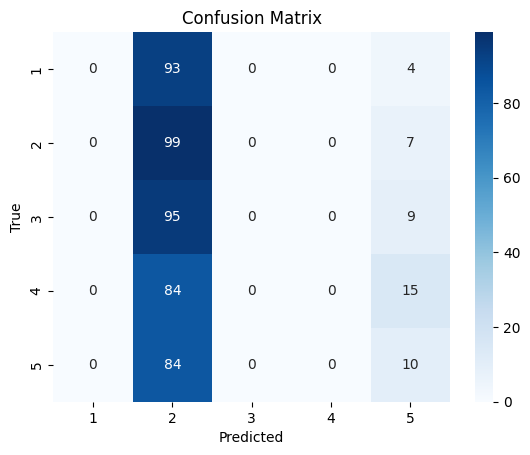

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

preds_output = trainer.predict(tokenized_dataset["test"])
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Train the Model

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,1.031500,0.980544,0.002800,0.568000,0.567569,0.568000,0.565879
2,0.945500,0.970941,0.002800,0.564000,0.581435,0.564000,0.568804
3,0.899800,0.954395,0.002800,0.574000,0.575076,0.574000,0.573382
4,0.857200,0.950168,0.002800,0.594000,0.590738,0.594000,0.592204
5,0.799200,0.972811,0.002800,0.606000,0.597209,0.606000,0.599784


TrainOutput(global_step=2815, training_loss=0.9558771729681039, metrics={'train_runtime': 379.5944, 'train_samples_per_second': 59.274, 'train_steps_per_second': 7.416, 'total_flos': 1515977786880000.0, 'train_loss': 0.9558771729681039, 'epoch': 5.0})

# Evaluate on Test Set

In [ ]:

metrics = trainer.evaluate()
print("\n📊 Evaluation Metrics:")
print(metrics)



📊 Evaluation Metrics:
{'eval_loss': 0.972811222076416, 'eval_model_preparation_time': 0.0028, 'eval_accuracy': 0.606, 'eval_precision': 0.5972094148985465, 'eval_recall': 0.606, 'eval_f1': 0.5997840707084817, 'eval_runtime': 3.6604, 'eval_samples_per_second': 136.596, 'eval_steps_per_second': 17.211, 'epoch': 5.0}


In [ ]:
print("\n Prediction AFTER training:")
print(f"Input: {sample_text}")
print(f"Predicted rating: {classify(sample_text) + 1} stars")


 Prediction AFTER training:
Input: The food and service were absolutely amazing!
Predicted rating: 5 stars


 # Plot Confusion Matrix

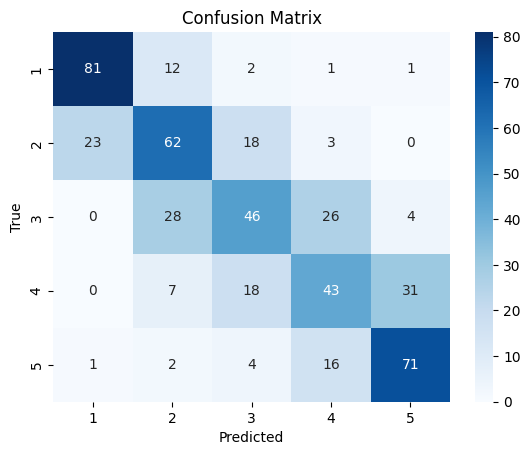

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

preds_output = trainer.predict(tokenized_dataset["test"])
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Text Summarizer

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
from huggingface_hub import login
import torch

# Load a summarization dataset
dataset = load_dataset("xsum", split="train[:1%]").train_test_split(test_size=0.1)

# Prompt-style formatting (natural continuation, not chat)
prompt_template = "Article: {input}\nSummary:"

README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


(…)SUM-EMNLP18-Summary-Data-Original.tar.gz:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

# Inspect the structure and examples in XSum dataset

In [ ]:

print(" Features:", dataset["train"].features)


for i in range(3):
    print(f"\n Example {i+1}:")
    print("Document:", dataset["train"][i]["document"][:300], "...")
    print("Summary :", dataset["train"][i]["summary"])


 Features: {'document': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}

 Example 1:
Document: Channel 4 has also fined Glasspool an undisclosed sum which he will give to a domestic violence charity.
"I am truly sorry to anyone I have upset or offended," he said.
"I would never condone domestic violence in any way and on reflection see that my video was insensitive and inappropriate."
The 24- ...
Summary : Hollyoaks actor Parry Glasspool has been suspended after posting a video in which he mimicked a woman threatening to stab her boyfriend to death.

 Example 2:
Document: The London Paramount resort on the Swanscombe Peninsula, near Dartford, would be twice the size of the Olympic Park, and include 5,000 hotel rooms and a water park.
The developers said they needed to conduct more research into traffic and environmental issues before applying for a development consen ...
Summary : The opening date of a £2bn theme park in 

In [ ]:
def preprocess(example):
    example["text"] = prompt_template.format(input=example["document"]) + " " + example["summary"]
    return example

# Format each example
dataset = dataset.map(preprocess)

Map:   0%|          | 0/1836 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

In [ ]:
print(" Features:", dataset["train"].features)
for i in range(3):
    print(f"\n Example {i+1}:")
    print(dataset["train"][i]["text"])

 Features: {'document': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}

 Example 1:
Article: Channel 4 has also fined Glasspool an undisclosed sum which he will give to a domestic violence charity.
"I am truly sorry to anyone I have upset or offended," he said.
"I would never condone domestic violence in any way and on reflection see that my video was insensitive and inappropriate."
The 24-year-old, who plays Harry Thompson, joined the soap to play student Harry last year and was nominated for best newcomer at this year's National Television Awards.
The clip was posted to the actor's Instagram account in June and featured him waving a knife in front of the camera.
He took on the role of a woman warning her boyfriend about talking to other girls, saying: "I would kill you if you did... With this knife I know exactly how to.
"Done it before and I'll do it again so don't even think ab

# Load tokenizer for a smaller causal LM

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token  # Ensure pad token is defined

def tokenize(example):
    input_ids = tokenizer(example["text"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    example["input_ids"] = input_ids["input_ids"][0]
    example["attention_mask"] = input_ids["attention_mask"][0]
    example["labels"] = input_ids["input_ids"][0].clone()
    return example

# Tokenize all data
tokenized_dataset = dataset.map(tokenize)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])



tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Map:   0%|          | 0/1836 [00:00<?, ? examples/s]

Map:   0%|          | 0/204 [00:00<?, ? examples/s]

# Load a small causal LM and apply LoRA

In [ ]:

base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

trainable params: 294,912 || all params: 125,493,504 || trainable%: 0.2350


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"]
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
def generate_summary(article):
    prompt = prompt_template.format(input=article)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_new_tokens=60)
    return tokenizer.decode(output[0], skip_special_tokens=True)

sample = dataset["test"][9]["document"]
print("Before training:\n", generate_summary(sample))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Before training:
 Article: Shaun Murphy, 38, died in hospital after was he was found injured in Greenbrow Road, Wythenshawe on Saturday.
A 23-year-old man is in custody for questioning, Greater Manchester Police said.
Det Ch Insp Jane Higham said: "This investigation is still in it's early stages and we are continuing to follow a number of lines of inquiry."
Summary: The man was found in the Greenbrow Road area of Wythenshawe on Saturday.
A 23-year-old man is in custody for questioning, Greater Manchester Police said.
Det Ch Insp Jane Higham said: "This investigation is still in it's early stages and we are continuing


# 🚀 Fine-tune the model

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.108700,2.913024
2,2.891600,2.899269
3,2.876800,2.895364
4,3.014800,2.894208
5,2.739000,2.893814


TrainOutput(global_step=2295, training_loss=2.9059920840793185, metrics={'train_runtime': 480.2464, 'train_samples_per_second': 19.115, 'train_steps_per_second': 4.779, 'total_flos': 1203098977566720.0, 'train_loss': 2.9059920840793185, 'epoch': 5.0})

# Test after training

In [ ]:
 print("\nAfter training:\n", generate_summary(sample))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



After training:
 Article: Shaun Murphy, 38, died in hospital after was he was found injured in Greenbrow Road, Wythenshawe on Saturday.
A 23-year-old man is in custody for questioning, Greater Manchester Police said.
Det Ch Insp Jane Higham said: "This investigation is still in it's early stages and we are continuing to follow a number of lines of inquiry."
Summary: A man has been arrested after being found injured in a car in the area of Wythenshawe.
